Importing

In [1]:
import torch; 
print(torch.cuda.is_available())

True


In [2]:
import vizdoom

import numpy as np

import random
import time
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt

from stable_baselines3.common import env_checker

import os
from stable_baselines3.common.callbacks import BaseCallback

from stable_baselines3 import PPO

from stable_baselines3.common.evaluation import evaluate_policy

Test run game using random actions

In [3]:
game = vizdoom.DoomGame()
game.load_config(r"vizdoom\scenarios\deadly_corridor_custom_skill1.cfg")
game.init()

actions = np.eye(7, dtype=np.uint8) # 3 actions: move left, move right, attack

episodes_count = 5
# Loop through the specified number of episodes
for episode in range(episodes_count):
    # Reset the game for a new episode
    game.new_episode()
    # Run while the episode is not finished
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer # Pixels
        info = state.game_variables # Ammo
        reward = game.make_action(random.choice(actions), 4) # 4 ticks per action
        print(f"Episode: {episode}, Reward: {reward}, Info: {info}")
        time.sleep(0.02)  # Slow down the loop for better readability
    print(f"Result: {game.get_total_reward()}")
    time.sleep(2)  # Pause before starting the next episode

game.close()
print("Game closed.")

Episode: 0, Reward: 0.0, Info: [100.   0.   0.  -1.]
Episode: 0, Reward: 0.0, Info: [100.   0.   0.  52.]
Episode: 0, Reward: -0.209564208984375, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 6.8586578369140625, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 5.542083740234375, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 3.3226470947265625, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 2.421356201171875, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 1.6330718994140625, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 1.1014251708984375, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 0.7428436279296875, Info: [100.   0.   0.  52.]
Episode: 0, Reward: 0.500946044921875, Info: [100.   0.   0.  52.]
Episode: 0, Reward: -2.475433349609375, Info: [100.   0.   0.  51.]
Episode: 0, Reward: -3.98028564453125, Info: [86.  0.  1. 51.]
Episode: 0, Reward: -5.773162841796875, Info: [86.  0.  1. 51.]
Episode: 0, Reward: -8.481307983398438, Info: [60.  0.  3. 51.]
Episode: 0, Reward: 4.8711

In [34]:
class VizDoomEnv(gym.Env):
    def __init__(self, config_path, render=False):
        super().__init__()

        # Setup the Doom game environment
        self.game = vizdoom.DoomGame()
        self.game.load_config(config_path)
        self.num_actions = 7  # Number of actions in the game (depends on scenario)

        if render:
            self.game.set_window_visible(True)
        else:
            self.game.set_window_visible(False)
        
        self.game.init()

        # Create action space and observation space
        self.action_space = gym.spaces.Discrete(self.num_actions)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(104, 160, 1),
            dtype=np.uint8
        )

        # Initialize previous values for shaping reward 
        self.previous_killcount = 0
        self.previous_hits_taken = 0
        self.selected_weapon_ammo = 26

    def step(self, action):

        actions = np.eye(self.num_actions, dtype=np.uint8)
        game_reward = self.game.make_action(actions[action], 4)  # 4 ticks per action
        terminated = self.game.is_episode_finished()

        state = self.game.get_state()
        if state is not None:
            observation = self.simplify_observation(state.screen_buffer)
            health, killcount, hits_taken, selected_weapon_ammo = state.game_variables
            # Calculate deltas for shaping reward
            delta_killcount = killcount - self.previous_killcount
            delta_hits_taken = hits_taken - self.previous_hits_taken
            delta_selected_weapon_ammo = selected_weapon_ammo - self.selected_weapon_ammo

            # Update previous values
            self.previous_killcount = killcount
            self.previous_hits_taken = hits_taken
            self.selected_weapon_ammo = selected_weapon_ammo


            # Calculate the shaped reward
            shaped_reward = (
                0.1 * game_reward
                + 0. * health
                + 5000.0 * delta_killcount
                - 1000.0 * delta_hits_taken
                + 5 * delta_selected_weapon_ammo
            )

            # print(f"Shaped_reward: {shaped_reward}, Killcount: {killcount}, Hits Taken: {hits_taken}, Selected Weapon Ammo: {selected_weapon_ammo}")

            info = {"info": 0}
        else:
            observation = np.zeros(self.observation_space.shape, dtype=np.uint8)
            shaped_reward = 0
            info = {"info": 0}

        return observation, shaped_reward, terminated, False, info
    
    def reset(self, seed=None):
        self.game.new_episode()
        state = self.game.get_state()
        observation = self.simplify_observation(state.screen_buffer)
        # health, killcount, hits_taken, selected_weapon_ammo = state.game_variables
        info = {"info": 0}

        self.previous_killcount = 0
        self.previous_hits_taken = 0
        self.selected_weapon_ammo = 26

        return observation, info
    
    def close(self):
        self.game.close()

    def simplify_observation(self, observation):
        # Convert the observation to grayscale and resize it
        gray_observation = cv2.cvtColor(np.moveaxis(observation,0,-1), cv2.COLOR_BGR2GRAY)
        cropped_obervation = gray_observation[:208, :]
        resized_observation = cv2.resize(cropped_obervation, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        simplified_observation = np.expand_dims(resized_observation, axis=-1)  # Add channel dimension
        return simplified_observation



In [5]:
env = VizDoomEnv(r"vizdoom\scenarios\deadly_corridor_custom_skill1.cfg", render=True)

In [6]:
observation = env.step(2)
# np.moveaxis(observation,0,-1)

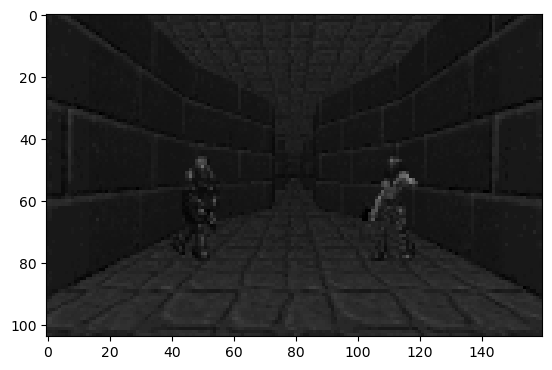

In [7]:
observation = env.reset()[0]
plt.imshow(cv2.cvtColor(observation, cv2.COLOR_BGR2RGB))

In [8]:
env.close()

In [25]:
# Check validity of the environment
env = VizDoomEnv(r"vizdoom\scenarios\deadly_corridor_custom_skill1.cfg")
env_checker.check_env(env)
env.close()

Callback (saving)

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

Train Model

In [ ]:
# Non rendered environment
env = VizDoomEnv(r"vizdoom\scenarios\deadly_corridor_custom_skill1.cfg")

In [40]:
# Model initialization
# model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-5, n_steps=2048)
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-4, n_steps=2048*4)
# model.learning_rate


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [41]:
skill_levels = [1]
model.learning_rate = 1e-4
for skill_level in skill_levels:
    env = VizDoomEnv(f'vizdoom\scenarios\deadly_corridor_custom_skill{skill_level}.cfg')
    model.set_env(env)
    model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_8
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 186       |
|    ep_rew_mean     | -3.31e+03 |
| time/              |           |
|    fps             | 110       |
|    iterations      | 1         |
|    time_elapsed    | 74        |
|    total_timesteps | 8192      |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 64        |
|    ep_rew_mean          | -9.04e+03 |
| time/                   |           |
|    fps                  | 89        |
|    iterations           | 2         |
|    time_elapsed         | 182       |
|    total_timesteps      | 16384     |
| train/                  |           |
|    approx_kl            | 1.8544194 |
|    clip_fraction        | 0.931     |
|    clip_range

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Test model

In [ ]:
# Reload model from disc
model = PPO.load('./train/train_corridor/best_model_300000')

In [ ]:
env = VizDoomEnv(r"vizdoom\scenarios\deadly_corridor_custom_skill2.cfg", render=True)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)

In [30]:
mean_reward

np.float64(36.87650230824947)

In [42]:
test_env = VizDoomEnv(r"vizdoom\scenarios\deadly_corridor_custom_skill2.cfg", render=True)
for episode in range(2): 
    obs = test_env.reset()[0]
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, _, info = test_env.step(action)
        time.sleep(0.2)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

test_env.close()

Total Reward for episode -5071.595631408692 is 0
Total Reward for episode -1116.5979965209963 is 1


In [39]:
test_env.close()